# Application of neural networks to mammography-based breast cancer diagnosis

*Thomas Templeton - n10118713 ; Parth Parekh - N10425314 ; Utkarsh Sinha - N10354093*

**Description:** 
Development of a sequential convoluted neural network (CNN) designed to identify benign and malignant cancer in mammogram images.

## Step 0: Set up the Python environment

In [1]:
import csv
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom
from skimage.measure import block_reduce
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# Configure plot display inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7.5]

## Step 1: Import the Data
First we need to import the data for the training, validation, and testing of the model. We start by importing the description of the mamography scans which are in the form of a CSV file. We are only interested in the binary diagnosis of Malignant or Benign (BENIGN_WITHOUT_CALLBACK will be included in the Benign diagnosis category)

In [4]:
# The path to the description cvs file
Description_File = 'D:\IFN646\Mamography_Images\calc_case_description_test_set.csv'

# The path to the directory containing all Mamography images
BaseDir = "D:\IFN646\Mamography_Images\CBIS-DDSM\\"

# Initialise the empty lists of diagnoses and location of corresponding mammogram image file
Diagnoses = []
File_Paths = []

# Extract diagnoses and file paths
with open(Description_File) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    
    for row in csv_reader:
        # Skip first line (headers)
        if line_count == 0:
            line_count += 1
        else:
            # Extract file path for mammogram image file
            Folder = re.findall(r'(.*)(_\d/)', row[13])[0][0] 
            for path in Path(BaseDir + Folder).rglob('*.dcm'):
                File_Path = str(path)
            File_Paths.append(File_Path)
            
            # Extract diagnoses
            Diagnosis = row[9]
            if Diagnosis == 'BENIGN_WITHOUT_CALLBACK':
                #Reclass BENIGN_WITHOUT_CALLBACK to BENIGN
                Diagnosis = 'BENIGN'
            Diagnoses.append(Diagnosis)
            
            line_count += 1

## Step 2: Pre-Processing the Data
Transform mammogram images into pixel arrays and then down sample and crop the arrays to the desired resolution:

In [6]:
# Initialise empty list of pixel arrays
PixelArrays = []

# Set the desired resolution (dimension) for down sampling and cropping
dim = 512

# Extraxt mammogram image
for File_Path in File_Paths:
    dimg = dicom.dcmread(File_Path)
    #Convert to pixel array
    PixelArray = dimg.pixel_array
    
    # Down sampling
    shape = PixelArray.shape
    x_factor = np.int(np.floor(shape[0]/dim))
    y_factor = np.int(np.floor(shape[1]/dim))
    PixelArray = block_reduce(PixelArray, block_size=(x_factor,y_factor), func=np.mean, cval=np.mean(PixelArray))
    
    # Cropping
    shape = PixelArray.shape
    x = shape[0] - dim
    y = shape[1] - dim
    
    start1 = np.int(np.floor(x/2))
    end1 = -np.int(np.ceil(x/2))
    start2 = np.int(np.floor(y/2))
    end2 = -np.int(np.ceil(y/2))
    
    if y > 0:
        PixelArray = PixelArray[:, start2:end2]
    if x > 0:
        PixelArray = PixelArray[start1:end1, :]   
    
    PixelArrays.append(PixelArray)

In [8]:
# Check desired resolution has been achieved for all mammograms
(MaxX, MaxY) = (0, 0)
(MinX, MinY) = (10000, 10000)

for Array in PixelArrays:
    shape = Array.shape
    if shape[0] > MaxX:
        MaxX = shape[0]
    if shape[1] > MaxY:
        MaxY = shape[1]
    if shape[0] < MinX:
        MinX = shape[0]
    if shape[1] < MinY:
        MinY = shape[1]
print(MaxX, MaxY)
print(MinX, MinY)

512 512
512 512


Build a list of binary inputs for the list of diagnoses:

In [9]:
# Build bninary classification input for diagnoses (Benign == 0, MALIGNANT == 1)
labels = []
for diagnosis in Diagnoses:
    if diagnosis == 'BENIGN':
        labels.append(0)
    elif diagnosis == 'MALIGNANT':
        labels.append(1)

Prepare the data (pixel arrays and binary list of diagnoses) for the CNN. This includes normalising the pixel array values, dividing data into training, validation, and testing sets, and reshaping input vectors to 4D:

In [10]:
# Convert to float32 and rescale between 0 and 1
ScaledPixelArrays = []
for array in PixelArrays:
    new_array = array.astype('float32')
    new_array /= 65535
    ScaledPixelArrays.append(new_array)

# number of training samples (60%), validation samples (20%), and testing samples (20%)
n = len(ScaledPixelArrays)
n_train = int(n * 0.6)
n_val = np.int((n - n_train) / 2)
n_test = n - n_train - n_val

# Split into training (60%), validation (20%), and testing (20%) 
train_labels, train_images = labels[:n_train], ScaledPixelArrays[:n_train]
val_labels, val_images = labels[n_train:n_train+n_val], ScaledPixelArrays[n_train:n_train+n_val]
test_labels, test_images = labels[n_train+n_val:], ScaledPixelArrays[n_train+n_val:]

# Convert list to array
train_labels, train_images = np.array(train_labels), np.array(train_images)
val_labels, val_images = np.array(val_labels), np.array(val_images)
test_labels, test_images = np.array(test_labels), np.array(test_images)

# Reshape the input arrays to 4D (batch_size, rows, columns, channels)
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
input_shape = train_images.shape[1:]

print(len(train_labels), len(train_images))
print(len(val_labels), len(val_images))
print(len(test_labels), len(test_images))
print()
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

195 195
65 65
66 66

(195, 512, 512, 1)
(65, 512, 512, 1)
(66, 512, 512, 1)


In [11]:
# Specify batch size and number of epochs
batch_size = 195
epochs = 9

## Step 2: Building the Convoluted Neural Network (CNN) Model
The model chosen for this project was a sequential CNN containing 7 2D convolution + maxPooling layers.

In [29]:
model = tf.keras.models.Sequential([
    
    # The first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # # The fifth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # # The sixth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # # The seventh convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),

    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),

    # Binary output neuron
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 510, 510, 32)      320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 253, 253, 64)      18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 124, 124, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 60, 64)       

In [30]:
# Compile CNN
model.compile(loss='binary_crossentropy', 
              optimizer=RMSprop(), 
              metrics=['accuracy'])

In [31]:
# Train and validate CNN
history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (val_images, val_labels), 
                    use_multiprocessing=False)

Train on 195 samples, validate on 65 samples
Epoch 1/9
195/195 [==============================] - 45s 232ms/sample - loss: 0.6933 - accuracy: 0.3949 - val_loss: 0.7280 - val_accuracy: 0.6154
Epoch 2/9
195/195 [==============================] - 67s 343ms/sample - loss: 0.6986 - accuracy: 0.6410 - val_loss: 0.6919 - val_accuracy: 0.6154
Epoch 3/9
195/195 [==============================] - 63s 325ms/sample - loss: 0.6918 - accuracy: 0.6410 - val_loss: 0.6842 - val_accuracy: 0.6154
Epoch 4/9
195/195 [==============================] - 60s 310ms/sample - loss: 0.6831 - accuracy: 0.6410 - val_loss: 0.8303 - val_accuracy: 0.6154
Epoch 5/9
195/195 [==============================] - 64s 330ms/sample - loss: 0.7677 - accuracy: 0.6410 - val_loss: 0.6894 - val_accuracy: 0.6154
Epoch 6/9
195/195 [==============================] - 67s 346ms/sample - loss: 0.6888 - accuracy: 0.6410 - val_loss: 0.6872 - val_accuracy: 0.6154
Epoch 7/9
195/195 [==============================] - 63s 322ms/sample - loss: 0

## Step 3: Evaluating the Model
Plot the learning curves for the training and validation datasets, followed by testing via predicting the diagnoses of the mammograms in the test set.

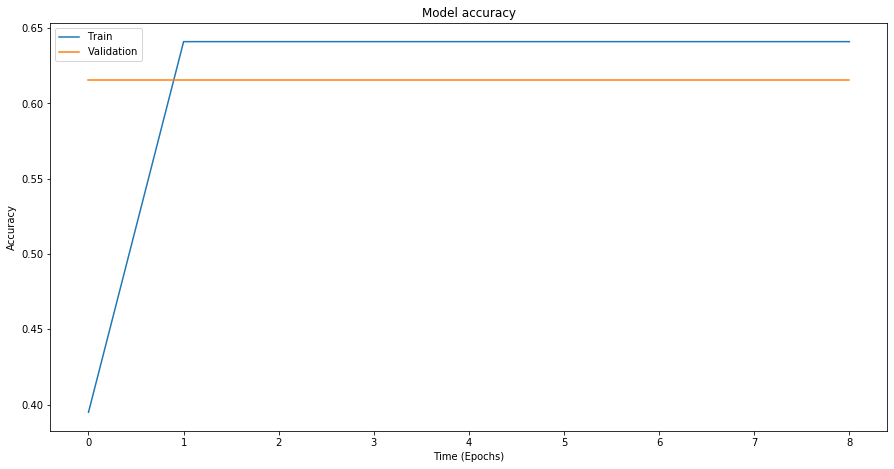

In [34]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Time (Epochs)')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

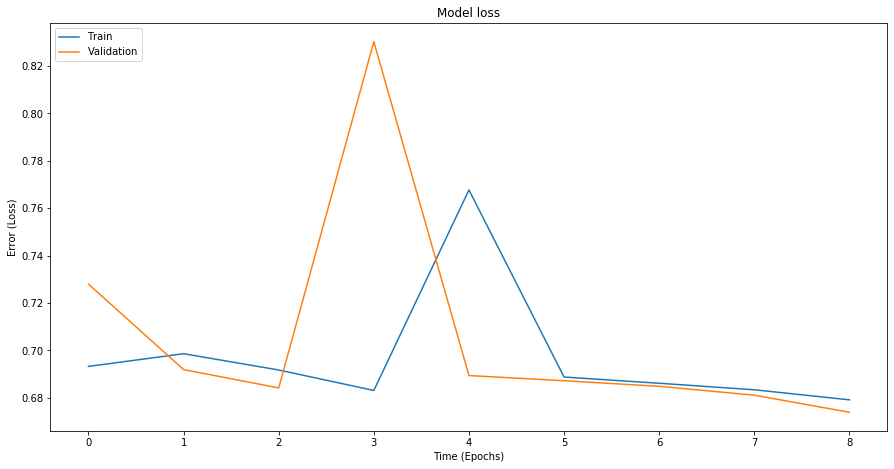

In [35]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Error (Loss)')
plt.xlabel('Time (Epochs)')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# Compute final accuracy on training, validation, and test sets
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

print('Calculating results...\n')

y_pred = model.predict((train_images, train_labels), verbose=1)
tr_acc = compute_accuracy(train_labels, y_pred)

y_pred = model.predict((val_images, val_labels), verbose=1)
val_acc = compute_accuracy(val_labels, y_pred)

y_pred = model.predict((test_images, test_labels), verbose=1)
te_acc = compute_accuracy(test_labels, y_pred)

# Print Results
print('Performance after %s epochs:' % epochs)
print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on validation set: %0.2f%%' % (100 * val_acc))
print('* Accuracy on Test set: %0.2f%%' % (100 * te_acc))

Calculating results...

66/66 [==============================] - 2s 27ms/sample
Performance after 9 epochs:
* Accuracy on training set: 35.90%
* Accuracy on validation set: 38.46%
* Accuracy on Test set: 51.52%
